## NLP project

Read all data

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
train_data = pd.read_csv('train.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
dev_data = pd.read_csv('dev.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
test_data = pd.read_csv('test.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])

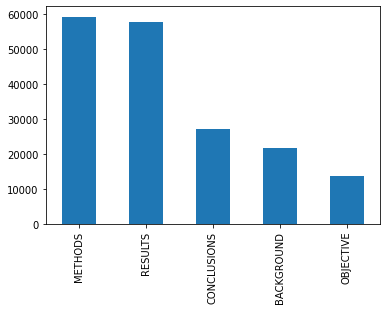

In [4]:
train_data['label'].value_counts().plot(kind='bar')

In [5]:
import spacy
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

nlp = spacy.load('en_core_web_sm')

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> ㅂ
Command 'ㅂ' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
# Cleaning process such that replacing punctuation to space, deleting them, or making them lowercase

def clean_text(text):
    
    punctuation = [i for i in ',./\\;:\'@#~[{]}=+-_)(*&^%$£"!`)]']
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.replace("'s", "")
    text = "".join([" " if t in punctuation else t for t in text]).lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

def split_training_set(X_train, y_train):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
    for first_index, second_index in skf.split(X_train, y_train):
        X_train_f, X_train_s = X_train[first_index], X_train[second_index]
        y_train_f, y_train_s = y_train[first_index], y_train[second_index]
        
    return X_train_f, y_train_f, X_train_s, y_train_s

def evaluate(y_true, y_pred):
    y_true = le.inverse_transform(y_true)
    y_pred = le.inverse_transform(y_pred)
    print(classification_report(y_true, y_pred))

### Which vectorizer is the best? Tf-idf vs Bag of words
This section aims to find out the best vectorizer that makes the first two machine learning models having better performance with respect to F1-score


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

In [8]:
%%time

train_text_cleaned = train_data['txt'].apply(clean_text)
devel_text_cleaned = dev_data['txt'].apply(clean_text)
test_text_cleaned = test_data['txt'].apply(clean_text)


CPU times: user 44.7 s, sys: 2.41 s, total: 47.1 s
Wall time: 48.4 s


In [9]:
le = LabelEncoder()
y_train = le.fit_transform(train_data['label'])
y_devel = le.transform(dev_data['label'])
y_test = le.transform(test_data['label'])

cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(zip(np.unique(y_train), cw))
cw_dict

{0: 1.657292769365306,
 1: 1.3253828032979977,
 2: 0.6066753154853166,
 3: 2.6019221041982803,
 4: 0.6213310786326851}

In [10]:
bow_vec = CountVectorizer(tokenizer=word_tokenize)
tfidf = TfidfVectorizer(tokenizer=word_tokenize)

random_seed = 42

bow_pipeline = Pipeline([
    ('bow', bow_vec),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])

tfidf_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])

print('-------Bag of word result----------')
bow_pipeline.fit(train_text_cleaned, y_train)
y_pred = bow_pipeline.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

print('-------TFIDF result----------')
tfidf_pipeline.fit(train_text_cleaned, y_train)
y_pred = tfidf_pipeline.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

-------Bag of word result----------
              precision    recall  f1-score   support

  BACKGROUND       0.52      0.58      0.55      3449
 CONCLUSIONS       0.65      0.68      0.67      4582
     METHODS       0.86      0.85      0.85      9964
   OBJECTIVE       0.50      0.55      0.53      2376
     RESULTS       0.88      0.82      0.84      9841

    accuracy                           0.76     30212
   macro avg       0.68      0.69      0.69     30212
weighted avg       0.77      0.76      0.76     30212

-------TFIDF result----------
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.60      0.57      3449
 CONCLUSIONS       0.65      0.71      0.68      4582
     METHODS       0.87      0.85      0.86      9964
   OBJECTIVE       0.51      0.61      0.56      2376
     RESULTS       0.89      0.80      0.85      9841

    accuracy                           0.77     30212
   macro avg       0.70      0.72      0.70     30212
weighted av

From the experiment, we noticed that TFIDF vectorizer is bit more effective to improve LR's performance.

Next, we need to discover the sufficient ngram range for TF-IDF vectorizer to have the best performance. This stage also considers the computational time for each ngram size simultaneously. 

*Result*
bigram and trigram show better performance than unigram. However, for trigram, it takes about 5minutes compared to 11 sec for unigram

ngram_range=(1,2) is reasonable to get feasible running time and better performance

In [ ]:
import time

ngram_candidates = [(1,1), (1,2), (1,3)]

for ngram in ngram_candidates:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram)),
        ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
    ])
    tick = time.time()
    pipeline.fit(train_text_cleaned, y_train)
    tock = time.time()
    print('Time elapsed:', tock-tick)
    y_pred = pipeline.predict(devel_text_cleaned)
    evaluate(y_devel, y_pred)

Time elapsed: 21.688993215560913
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.58      0.57      3449
 CONCLUSIONS       0.66      0.71      0.68      4582
     METHODS       0.87      0.85      0.86      9964
   OBJECTIVE       0.51      0.61      0.56      2376
     RESULTS       0.89      0.81      0.85      9841

    accuracy                           0.77     30212
   macro avg       0.69      0.71      0.70     30212
weighted avg       0.78      0.77      0.77     30212

Time elapsed: 137.30048251152039
              precision    recall  f1-score   support

  BACKGROUND       0.60      0.60      0.60      3449
 CONCLUSIONS       0.67      0.75      0.71      4582
     METHODS       0.87      0.87      0.87      9964
   OBJECTIVE       0.56      0.60      0.58      2376
     RESULTS       0.89      0.82      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.72      0.73      0.72     30212
weighted av

### Model1: Logistic Regression with Tf-idf vectorizer 

The first model which is the baseline model is to use logistic regression. The only given hyperparameter is balancing class weights for handling imbalanced data.

In [ ]:
ngram = (1,2)

model_1 = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=word_tokenize, ngram_range=ngram)),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])
model_1.fit(train_text_cleaned, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function word_tokenize at 0x7f9fcb4bd170>)),
                ('LR',
                 LogisticRegression(class_weight={0: 1.657292769365306,
                                                  1: 1.3253828032979977,
                                                  2: 0.6066753154853166,
                                                  3: 2.6019221041982803,
                                                  4: 0.6213310786326851},
                                    n_jobs=-1, random_state=42))])

In [ ]:
y_pred = model_1.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.59      0.60      0.59      3449
 CONCLUSIONS       0.65      0.75      0.70      4582
     METHODS       0.86      0.87      0.87      9964
   OBJECTIVE       0.55      0.64      0.59      2376
     RESULTS       0.90      0.80      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.71      0.73      0.72     30212
weighted avg       0.79      0.78      0.78     30212



### Model2: Linear SVM with Tf-idf Vectorizer

The next model is Linear SVM with the same technique for imbalanced data. Additional hyperparameter for SVM is cost parameter which is set to 1.

In [ ]:
model_2 = Pipeline([
    ("tf-idf", TfidfVectorizer(tokenizer=word_tokenize, ngram_range=ngram)),
    ("LinearSVM", LinearSVC(class_weight=cw_dict, random_state=random_seed, C=1))
])
model_2.fit(train_text_cleaned, y_train)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function word_tokenize at 0x7f1d65a39b00>)),
                ('LinearSVM',
                 LinearSVC(C=1,
                           class_weight={0: 1.657292769365306,
                                         1: 1.3253828032979977,
                                         2: 0.6066753154853166,
                                         3: 2.6019221041982803,
                                         4: 0.6213310786326851},
                           random_state=42))])

In [ ]:
y_pred = model_2.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.61      0.58      0.60      3449
 CONCLUSIONS       0.70      0.73      0.71      4582
     METHODS       0.85      0.91      0.88      9964
   OBJECTIVE       0.61      0.57      0.59      2376
     RESULTS       0.89      0.85      0.87      9841

    accuracy                           0.80     30212
   macro avg       0.73      0.73      0.73     30212
weighted avg       0.80      0.80      0.80     30212



### Model3: Conv1D network

#### Word Embedding layer
Prior to build word embedding layer, the texts were vectorized using `TextVectorization`. The vectors are encoded as 296 word sequence length which is the maximum length in the entire sentences in the training set. The max size of vocabulary of this vectorizer is 68,000 which is the total number of vocabulary in the training set. After vectorizing, embedding dimension is set to 150 as my machine can handle.
#### Conv1D layer
- filter_size = 64
- kernel_size = 5
- activation = ReLU
- Dropout = 0.2

#### Training setting
- epochs = 3
- batch_size = 256
- balancing class weights

Such setting follows the codes from practical session

In [10]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

sentence_len = [len(sent.split()) for sent in train_data['txt'].tolist()]
np.percentile(sentence_len, 95)

55.0

In [11]:
max_tokens = 68000
seq_len = 55

text_vec = TextVectorization(max_tokens=max_tokens, 
                             pad_to_max_tokens=True, 
                             output_sequence_length=seq_len,
                             output_mode='int')
text_vec.adapt(train_text_cleaned)

In [26]:
from tensorflow.keras.utils import to_categorical, set_random_seed
from keras.layers import Embedding, Dropout, Dropout, Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, Bidirectional, LSTM, Input
from sklearn.metrics import f1_score

random_seed = 42
embedding_dim = 200
hidden_dims=32
filter1 = 64
kernel_size=5
dropout_rate=0.2
input_dim = len(text_vec.get_vocabulary())
set_random_seed(random_seed)
# np.set_random_seed(random_seed)

y_train_vec = to_categorical(y_train, num_classes=5, dtype=int)
y_devel_vec = to_categorical(y_devel, num_classes=5, dtype=int)
y_test_vec = to_categorical(y_test, num_classes=5, dtype=int)

# x_train = pad_sequences(train_text_cleaned, maxlen=seq_len)
# x_test = pad_sequences(devel_text_cleaned, maxlen=seq_len)

In [27]:
model_3 = tf.keras.Sequential()

model_3.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model_3.add(text_vec)
model_3.add(Embedding(input_dim=input_dim,
                    output_dim=embedding_dim,
                    mask_zero=True,
                   input_length=seq_len))
# model_3.add(Conv1D(filter1,
#                  kernel_size,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# model_3.add(GlobalMaxPooling1D())
model_3.add(LSTM(filter1, return_sequences=False))
model_3.add(Dropout(0.3))

model_3.add(Dense(hidden_dims, activation='relu'))
model_3.add(Dropout(0.3))

model_3.add(Dense(5, activation='softmax'))

model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Finished building model.\n')
print(model_3.summary())

Finished building model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 200)           11580400  
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                              

In [23]:
model_3.fit(train_text_cleaned, y_train_vec, class_weight=cw_dict, batch_size=256, epochs=5, validation_data=(devel_text_cleaned, y_devel_vec))
# y_train_vec

Epoch 1/5
704/704 [==============================] - 27s 32ms/step - loss: 0.8947 - accuracy: 0.7065 - val_loss: 0.6201 - val_accuracy: 0.7763
Epoch 2/5
704/704 [==============================] - 29s 42ms/step - loss: 0.6419 - accuracy: 0.8056 - val_loss: 0.6193 - val_accuracy: 0.7753
Epoch 3/5
704/704 [==============================] - 24s 34ms/step - loss: 0.5213 - accuracy: 0.8428 - val_loss: 0.6378 - val_accuracy: 0.7739
Epoch 4/5
704/704 [==============================] - 26s 38ms/step - loss: 0.4257 - accuracy: 0.8702 - val_loss: 0.7164 - val_accuracy: 0.7671
Epoch 5/5
704/704 [==============================] - 18s 26ms/step - loss: 0.3532 - accuracy: 0.8913 - val_loss: 0.7759 - val_accuracy: 0.7665


In [24]:
y_pred_vec = model_3.predict(test_text_cleaned)
y_pred = np.argmax(y_pred_vec, axis=1)
evaluate(y_test, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.56      0.55      0.56      3621
 CONCLUSIONS       0.65      0.68      0.66      4571
     METHODS       0.86      0.86      0.86      9897
   OBJECTIVE       0.51      0.63      0.57      2333
     RESULTS       0.87      0.81      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.69      0.71      0.70     30135
weighted avg       0.77      0.76      0.76     30135



### Model4: Different embedding layer with the Conv1D network

In [29]:
from numpy import array

embeddings_index = dict()
f = open('glove.6B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [30]:
embedding_matrix = np.zeros((input_dim + 1, embedding_dim))
for i, word in enumerate(text_vec.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_layer = Embedding(input_dim + 1, 
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=seq_len,
                            trainable=False,
                            name='embedding_layer')

In [32]:
model_4 = tf.keras.Sequential()

model_4.add(Input(shape=(1,), dtype=tf.string))
model_4.add(text_vec)
model_4.add(embedding_layer)
# model_4.add(Conv1D(filter1,
#                  kernel_size,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# model_4.add(GlobalMaxPooling1D())
model_4.add(Bidirectional(LSTM(filter1, return_sequences=False)))
model_4.add(Dropout(0.2))
model_4.add(Dense(hidden_dims, activation='relu'))
model_4.add(Dropout(0.2))

model_4.add(Dense(5, activation='softmax'))

model_4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Finished building model.\n')
print(model_4.summary())

Finished building model.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 55, 200)          11580600  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)        

In [33]:
model_4.fit(train_text_cleaned, y_train_vec, class_weight=cw_dict, batch_size=256, epochs=5, validation_data=(devel_text_cleaned, y_devel_vec))
# y_train_vec

Epoch 1/5
704/704 [==============================] - 21s 18ms/step - loss: 0.9184 - accuracy: 0.6841 - val_loss: 0.6507 - val_accuracy: 0.7606
Epoch 2/5
704/704 [==============================] - 11s 15ms/step - loss: 0.7511 - accuracy: 0.7561 - val_loss: 0.6302 - val_accuracy: 0.7670
Epoch 3/5
704/704 [==============================] - 11s 15ms/step - loss: 0.7001 - accuracy: 0.7761 - val_loss: 0.5757 - val_accuracy: 0.7876
Epoch 4/5
704/704 [==============================] - 11s 15ms/step - loss: 0.6660 - accuracy: 0.7879 - val_loss: 0.5670 - val_accuracy: 0.7893
Epoch 5/5
704/704 [==============================] - 11s 15ms/step - loss: 0.6407 - accuracy: 0.7960 - val_loss: 0.5743 - val_accuracy: 0.7894


In [34]:
y_pred_vec = model_4.predict(test_text_cleaned)
y_pred = np.argmax(y_pred_vec, axis=1)
evaluate(y_test, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.56      0.64      0.60      3621
 CONCLUSIONS       0.68      0.71      0.70      4571
     METHODS       0.88      0.88      0.88      9897
   OBJECTIVE       0.57      0.64      0.60      2333
     RESULTS       0.91      0.81      0.86      9713

    accuracy                           0.78     30135
   macro avg       0.72      0.74      0.73     30135
weighted avg       0.80      0.78      0.79     30135



### Model5: Model from the paper

According to the paper [(Neural Networks for Joint Sentence classification in Mecial Paper Abstracts)](https://arxiv.org/pdf/1612.05251.pdf), the suggested model outperforms other baseline models such as Logistic Regression, Forward ANN, and CRF. The last model follows the instructions at the paper.

- Additional information for the model is to label which line is the corresponding sentence in the abstract and give the total number of lines in the abstract.
This should be effective because abstracts are typically structured writing especially medical paper. Additionally, it is obvious the 'METHOD' part is followed by 'RESULT' part. Such information would be helpful for the model to classify the sentence.

In [21]:
def cal_lines(data):
  lines = []
  current = 0
  count = 0
  data['total_lines'] = 0
  for i, id in enumerate(data['pmid']):
      if current != id:
          data['total_lines'][i-count:i] = count
          current = id
          count = 1
      else:
          count += 1
      lines.append(count)

  data['total_lines'][i-count+1:] = count
  data['line_number'] = lines
  return data

train_data = cal_lines(train_data)
dev_data = cal_lines(dev_data)
test_data = cal_lines(test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [68]:
from keras.layers import Concatenate
from tensorflow.keras import Model

line_model_input = Input(shape=(2,), dtype=tf.int32, name="line_model_input")
line_model_dense = Dense(hidden_dims, activation='relu', name="line_model_dense")(line_model_input)
line_model = Model(inputs=line_model_input, outputs=line_model_dense)

token_model_input = Input(shape=(1,), dtype=tf.string, name="token_model_input")
token_vector = text_vec(token_model_input)
token_embedding = embedding_layer(token_vector)
token_bilstm = Bidirectional(LSTM(filter1, return_sequences=False, name='bi-lstm'))(token_embedding)
token_bilstm = Dropout(dropout_rate)(token_bilstm)
token_dense = Dense(hidden_dims, activation='relu', name='token_dense')(token_bilstm)
token_dense = Dropout(dropout_rate)(token_dense)
token_model = Model(inputs=token_model_input, outputs=token_dense)

concat = Concatenate()([token_model.output, line_model.output])
dense_last = Dense(hidden_dims, activation='relu', name='last_dense')(concat)
dense_last = Dropout(0.2)(dense_last)

output = Dense(5, activation='softmax')(dense_last)

model_5 = Model(inputs=[
                        line_model.input,
                        token_model.input],
                outputs=output)


model_5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_5.summary())

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_model_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_model_input[0][0]']      
 ization)                                                                                         
                                                                                                  
 embedding_layer (Embedding)    (None, 55, 200)      11580600    ['text_vectorization[11][0]']    
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 128)         135680      ['embedding_layer[9][0]'] 

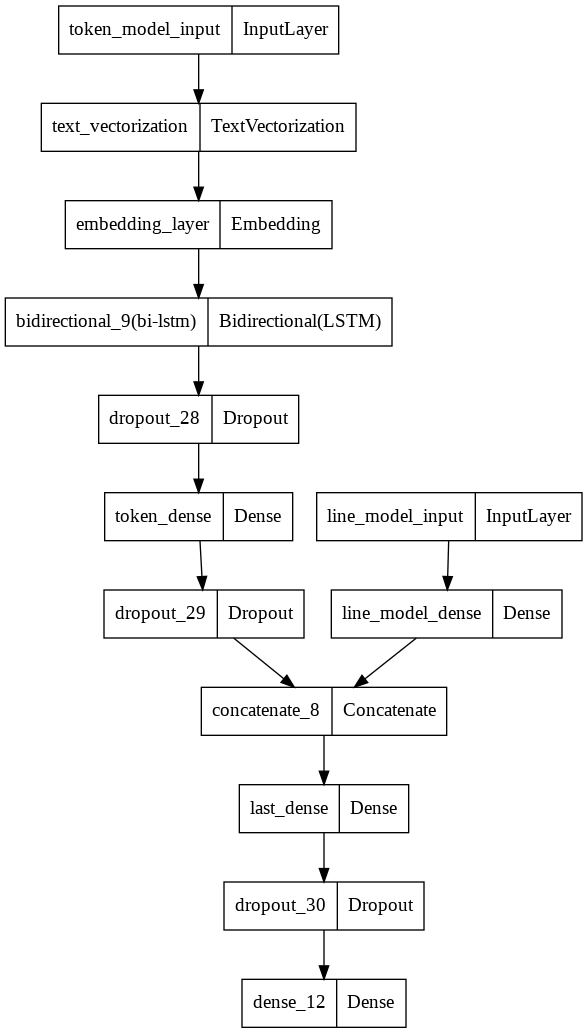

In [69]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [70]:
model_5.fit([train_data[['line_number', 'total_lines']], train_text_cleaned], 
            y_train_vec, 
            epochs=5, 
            batch_size=256, 
            validation_data=([dev_data[['line_number', 'total_lines']], devel_text_cleaned], y_devel_vec))

Epoch 1/5
704/704 [==============================] - 16s 19ms/step - loss: 0.5673 - accuracy: 0.7848 - val_loss: 0.3522 - val_accuracy: 0.8669
Epoch 2/5
704/704 [==============================] - 11s 16ms/step - loss: 0.3879 - accuracy: 0.8585 - val_loss: 0.3276 - val_accuracy: 0.8761
Epoch 3/5
704/704 [==============================] - 11s 16ms/step - loss: 0.3583 - accuracy: 0.8699 - val_loss: 0.3199 - val_accuracy: 0.8776
Epoch 4/5
704/704 [==============================] - 12s 17ms/step - loss: 0.3416 - accuracy: 0.8763 - val_loss: 0.3152 - val_accuracy: 0.8790
Epoch 5/5
704/704 [==============================] - 11s 16ms/step - loss: 0.3274 - accuracy: 0.8816 - val_loss: 0.3095 - val_accuracy: 0.8821


In [71]:
y_pred_vec = model_5.predict([test_data[['line_number', 'total_lines']], test_text_cleaned])
y_pred = np.argmax(y_pred_vec, axis=1)
evaluate(y_test, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.73      0.85      0.79      3621
 CONCLUSIONS       0.94      0.89      0.91      4571
     METHODS       0.91      0.95      0.93      9897
   OBJECTIVE       0.78      0.54      0.64      2333
     RESULTS       0.92      0.91      0.91      9713

    accuracy                           0.88     30135
   macro avg       0.85      0.83      0.83     30135
weighted avg       0.88      0.88      0.88     30135

